In [1]:
from functools import partial

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('darkgrid')

from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoModel, AlbertTokenizerFast

from data import SNLIDataset
from data.utils import get_data, collate_fn_biencoder

from model import NLIBiEncoder

from training import Trainer

# Data

In [2]:
train, test, val = get_data('snli_1.0')

In [3]:
LABELS = ['entailment', 'contradiction', 'neutral']
NUM_LABELS = len(LABELS)

train = train[train.target.isin(set(LABELS))]
val = val[val.target.isin(set(LABELS))]
test = test[test.target.isin(set(LABELS))]

In [4]:
train.head()

,sentence1,sentence2,target
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [5]:
target2idx = {l: i for i, l in enumerate(LABELS)}
train.target = train.target.map(target2idx)
val.target = val.target.map(target2idx)
test.target = test.target.map(target2idx)

In [6]:
albert_tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')

In [7]:
train_dataset = SNLIDataset(train.sentence1.tolist(), train.sentence2.tolist(), train.target.tolist())
val_dataset = SNLIDataset(val.sentence1.tolist(), val.sentence2.tolist(), val.target.tolist())

In [8]:
collate_fn_biencoder = partial(collate_fn_biencoder, tokenizer=albert_tokenizer)

train_loader = DataLoader(train_dataset, batch_size=56, shuffle=True, collate_fn=collate_fn_biencoder)
val_loader = DataLoader(val_dataset, batch_size=56, shuffle=False, collate_fn=collate_fn_biencoder)

# Model

In [9]:
albert = AutoModel.from_pretrained('albert-base-v2')

In [10]:
model = NLIBiEncoder(albert, NUM_LABELS, lambda x: x.pooler_output)

In [11]:
criterion = nn.CrossEntropyLoss()
trainer = Trainer(model, criterion, 'albert/v2/albert_snli.pt', 'albert/v2/albert_optimizer.pt', lr=1e-4, device='cuda:0')

# Training

In [12]:
trainer.train(train_loader, val_loader, num_epochs=30, frozen_encoder_epochs=1)

Epoch 1/30:


Mean loss: 1.0447264240980147. Current progress: : 100%|██████████| 9811/9811 [15:45<00:00, 10.38it/s]


Mean training loss: 1.0581103308146644. Mean validation loss: 1.0361552489074795.
Training accuracy: 0.4285277419284376. Validation accuracy: 0.45490635179153094.
Epoch 2/30:


Mean loss: 0.658087312757969. Current progress: : 100%|██████████| 9811/9811 [41:00<00:00,  3.99it/s] 


Mean training loss: 0.7314991576416924. Mean validation loss: 0.6271027927710251.
Training accuracy: 0.6864372996557857. Validation accuracy: 0.750814332247557.
Epoch 3/30:


Mean loss: 0.6010515168905258. Current progress: : 100%|██████████| 9811/9811 [41:38<00:00,  3.93it/s]


Mean training loss: 0.6037406535271828. Mean validation loss: 0.5581727419048548.
Training accuracy: 0.7556897301803712. Validation accuracy: 0.7756514657980456.
Epoch 4/30:


Mean loss: 0.5276459250748158. Current progress: : 100%|██████████| 9811/9811 [41:32<00:00,  3.94it/s]


Mean training loss: 0.5418156106702755. Mean validation loss: 0.5262769470837984.
Training accuracy: 0.7853930068606232. Validation accuracy: 0.7890879478827362.
Epoch 5/30:


Mean loss: 0.4968908171057701. Current progress: : 100%|██████████| 9811/9811 [42:25<00:00,  3.85it/s] 


Mean training loss: 0.4960836751185089. Mean validation loss: 0.5058354212140496.
Training accuracy: 0.8069232407479882. Validation accuracy: 0.7989617263843648.
Epoch 6/30:


Mean loss: 0.4619516331255436. Current progress: : 100%|██████████| 9811/9811 [41:11<00:00,  3.97it/s] 


Mean training loss: 0.4561202142696329. Mean validation loss: 0.5015300872989676.
Training accuracy: 0.8250422759284777. Validation accuracy: 0.8037459283387622.
Epoch 7/30:


Mean loss: 0.4219388979822397. Current progress: : 100%|██████████| 9811/9811 [41:33<00:00,  3.93it/s] 


Mean training loss: 0.41782737674136344. Mean validation loss: 0.5040639810772105.
Training accuracy: 0.8424022556869998. Validation accuracy: 0.8038477198697068.
Epoch 8/30:


Mean loss: 0.3845897646099329. Current progress: : 100%|██████████| 9811/9811 [41:51<00:00,  3.91it/s] 


Mean training loss: 0.3792671325056758. Mean validation loss: 0.5213697989555922.
Training accuracy: 0.8586427652188792. Validation accuracy: 0.8083265472312704.
Epoch 9/30:


Mean loss: 0.368887455239892. Current progress: : 100%|██████████| 9811/9811 [41:16<00:00,  3.96it/s]  


Mean training loss: 0.35117821006199085. Mean validation loss: 0.5351950878446753.
Training accuracy: 0.8705856012465255. Validation accuracy: 0.8009975570032574.
Validation performance has started degrading. Performing early stopping.


NLIBiEncoder(
  (encoder): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
      

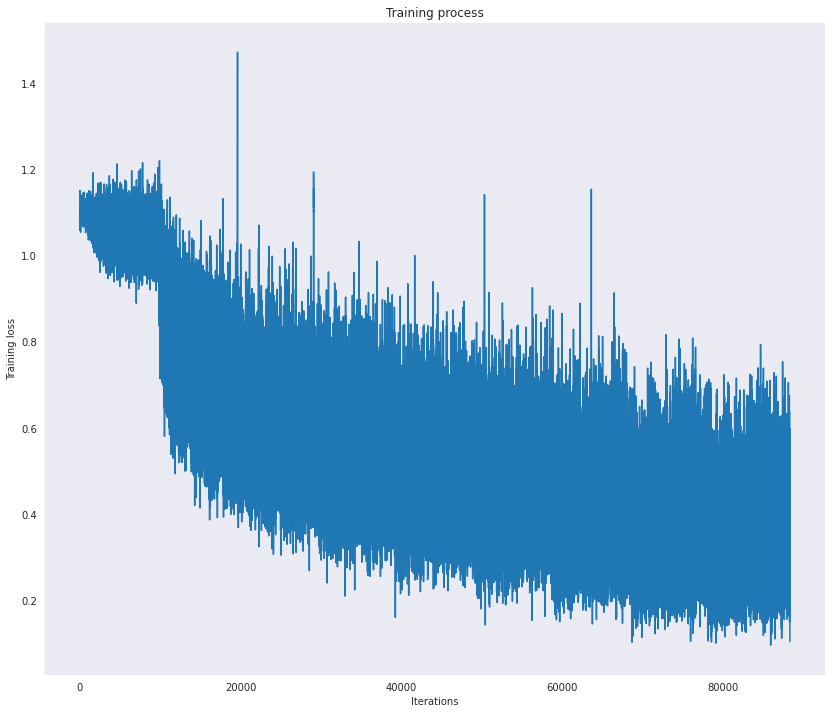

In [13]:
plt.figure(figsize=(14, 12))
plt.plot(trainer.train_losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Training loss');